# OpenRouter + Prompt Caching

In [2]:
from openai import OpenAI
from os import getenv

# gets API Key from environment variable OPENAI_API_KEY
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=getenv("OPENROUTER_API_KEY"),
)

completion = client.chat.completions.create(
  model="meta-llama/llama-4-maverick",  # https://openrouter.ai/meta-llama/llama-4-maverick
  messages=[
    {
      "role": "user",
      "content": "Who are you?",
    },
  ],
)
print(completion.choices[0].message.content)


I'm an AI assistant designed by Meta. I'm here to answer your questions, share interesting ideas and maybe even surprise you with a fresh perspective. What's on your mind?


# Using Langchain instead of API (Sinan's Recommendation)

In [3]:
from langchain_core.prompts import ChatPromptTemplate

template = ChatPromptTemplate([
    ("system", "You are a helpful AI bot. Your name is {name} and you answer questions."),
    ("human", "{question}"),
])

question = "What NFL team won the Super Bowl in the year Sinan Ozdemir was born?"


filled_in_prompt = template.invoke(
    {
        "name": "Kylie",
        "question": question
    }
)

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
filled_in_prompt

ChatPromptValue(messages=[SystemMessage(content='You are a helpful AI bot. Your name is Kylie and you answer questions.', additional_kwargs={}, response_metadata={}), HumanMessage(content='What NFL team won the Super Bowl in the year Sinan Ozdemir was born?', additional_kwargs={}, response_metadata={})])

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
  openai_api_key=getenv("OPENROUTER_API_KEY"),
  openai_api_base="https://openrouter.ai/api/v1",
  model_name="meta-llama/llama-4-maverick",
)


ai_message = llm.invoke(filled_in_prompt)
ai_message

AIMessage(content='Sinan Ozdemir was born in 1992. The NFL team that won Super Bowl XXVI in 1992 was the Washington Redskins. They defeated the Buffalo Bills 37-24 on January 26, 1992.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 52, 'total_tokens': 103, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/llama-4-maverick', 'system_fingerprint': None, 'id': 'gen-1748881137-VVX02yXHWBxxmxSnrgtH', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--b0918410-f23e-4b76-97af-0a659906f7f0-0', usage_metadata={'input_tokens': 52, 'output_tokens': 51, 'total_tokens': 103, 'input_token_details': {}, 'output_token_details': {}})

In [6]:
ai_message.content

'Sinan Ozdemir was born in 1992. The NFL team that won Super Bowl XXVI in 1992 was the Washington Redskins. They defeated the Buffalo Bills 37-24 on January 26, 1992.'

In [7]:
ai_message.response_metadata

{'token_usage': {'completion_tokens': 51,
  'prompt_tokens': 52,
  'total_tokens': 103,
  'completion_tokens_details': None,
  'prompt_tokens_details': None},
 'model_name': 'meta-llama/llama-4-maverick',
 'system_fingerprint': None,
 'id': 'gen-1748881137-VVX02yXHWBxxmxSnrgtH',
 'service_tier': None,
 'finish_reason': 'stop',
 'logprobs': None}

In [8]:
ai_message.usage_metadata

{'input_tokens': 52,
 'output_tokens': 51,
 'total_tokens': 103,
 'input_token_details': {},
 'output_token_details': {}}

In [9]:
# add the AI message to the thread
filled_in_prompt.messages.append(ai_message)

In [10]:
from langchain_core.messages import HumanMessage
filled_in_prompt.messages.append(HumanMessage(content="and what's your name?"))


new_ai_message = llm.invoke(filled_in_prompt)
new_ai_message

AIMessage(content="My name is Kylie. I'm here to help answer your questions!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 115, 'total_tokens': 130, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/llama-4-maverick', 'system_fingerprint': None, 'id': 'gen-1748881137-o9MlFU1kOtfTUwD6spff', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--c2c47b9d-a77d-490f-a297-331225f19279-0', usage_metadata={'input_tokens': 115, 'output_tokens': 15, 'total_tokens': 130, 'input_token_details': {}, 'output_token_details': {}})

In [11]:
new_ai_message.content

"My name is Kylie. I'm here to help answer your questions!"

In [12]:
new_ai_message.response_metadata

{'token_usage': {'completion_tokens': 15,
  'prompt_tokens': 115,
  'total_tokens': 130,
  'completion_tokens_details': None,
  'prompt_tokens_details': None},
 'model_name': 'meta-llama/llama-4-maverick',
 'system_fingerprint': None,
 'id': 'gen-1748881137-o9MlFU1kOtfTUwD6spff',
 'service_tier': None,
 'finish_reason': 'stop',
 'logprobs': None}

# Prompt Caching with OpenRouter + OpenAI

In [13]:
llm_with_caching = ChatOpenAI(
  openai_api_key=getenv("OPENROUTER_API_KEY"),
  openai_api_base="https://openrouter.ai/api/v1",
  model_name="openai/gpt-4.1-nano",
)


In [14]:
from datasets import load_dataset

# https://huggingface.co/datasets/mandarjoshi/trivia_qa is a big dataset, only grabbing the first 500!

ds_stream = load_dataset("mandarjoshi/trivia_qa", "rc", split="train", streaming=True)
first_500 = [x for _, x in zip(range(500), ds_stream)]


Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

In [15]:
all_wikis = [f['entity_pages']['wiki_context'][0] for f in first_500 if 'entity_pages' in f and len(f['entity_pages']['wiki_context'])]

In [16]:
import random
random_all_wikis = random.sample(all_wikis, 20)

In [17]:
len(all_wikis), len(random_all_wikis)

(392, 20)

In [18]:
# per documentation: "There is a minimum prompt size of 1024 tokens." for OpenAI
#  https://openrouter.ai/docs/features/prompt-caching

import time
template = ChatPromptTemplate([
    ("system", "You are a helpful AI bot and you answer questions. Here is some data to use {context}"),
    ("human", "{question}"),
])

time_to_finish = []
for datapoint in first_500[:10]:
    print(f"Question: {datapoint['question']}")

    filled_in_prompt = template.invoke(
        {
            "context": '\n'.join(random_all_wikis),
            "question": datapoint['question']
        }
    )
    time_before = time.time()
    ai_message = llm_with_caching.invoke(filled_in_prompt)
    time_after = time.time()
    seconds = (time_after - time_before)
    time_to_finish.append(seconds)
    token_usage = ai_message.response_metadata['token_usage']
    print(f"Seconds: {seconds}. Total Tokens: {token_usage['total_tokens']}.  Cached Tokens: {token_usage['prompt_tokens_details']['cached_tokens']}")

Question: Which American-born Sinclair won the Nobel Prize for Literature in 1930?
Seconds: 10.03646993637085. Total Tokens: 149517.  Cached Tokens: 0
Question: Where in England was Dame Judi Dench born?
Seconds: 2.2446017265319824. Total Tokens: 149505.  Cached Tokens: 149248
Question: In which decade did Billboard magazine first publish and American hit chart?
Seconds: 4.771224737167358. Total Tokens: 149512.  Cached Tokens: 149248
Question: From which country did Angola achieve independence in 1975?
Seconds: 2.7315890789031982. Total Tokens: 149506.  Cached Tokens: 149376
Question: Which city does David Soul come from?
Seconds: 2.725454092025757. Total Tokens: 149499.  Cached Tokens: 0
Question: Who won Super Bowl XX?
Seconds: 2.2838401794433594. Total Tokens: 149499.  Cached Tokens: 149248
Question: Which was the first European country to abolish capital punishment?
Seconds: 2.40966796875. Total Tokens: 149507.  Cached Tokens: 149248
Question: In which country did he widespread use

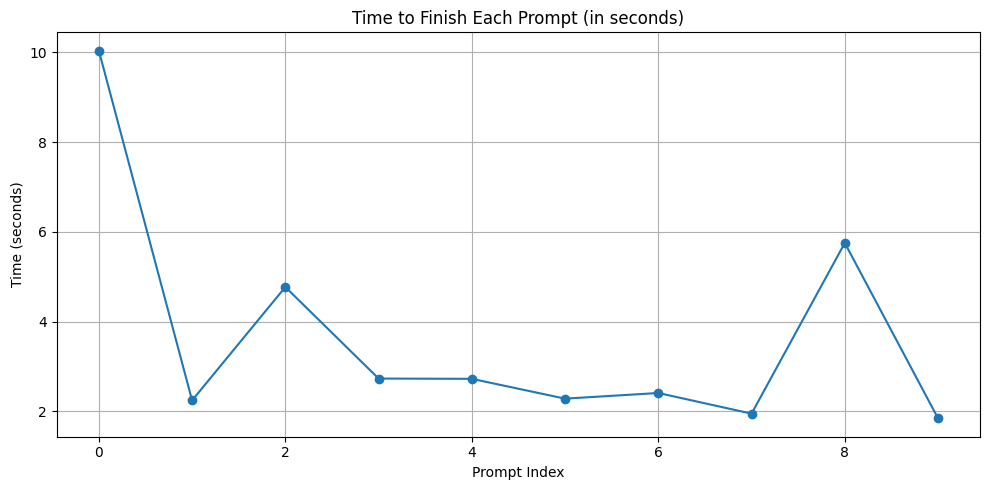

In [19]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time_to_finish, marker='o')
plt.title("Time to Finish Each Prompt (in seconds)")
plt.xlabel("Prompt Index")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# break the cache entirely by adding a single token

filled_in_prompt = template.invoke(
    {
        "context": "Here is that context:\n" + '\n'.join(random_all_wikis),
        "question": datapoint['question']
    }
)
time_before = time.time()
ai_message = llm_with_caching.invoke(filled_in_prompt)
time_after = time.time()
seconds = (time_after - time_before)
time_to_finish.append(seconds)
token_usage = ai_message.response_metadata['token_usage']
print(f"Seconds: {seconds}. Total Tokens: {token_usage['total_tokens']}.  Cached Tokens: {token_usage['prompt_tokens_details']['cached_tokens']}")

Seconds: 2.941303014755249. Total Tokens: 149511.  Cached Tokens: 0
